In [3]:
from CPlantBox_PiafMunch import * #import all the libraries

In [2]:
name = "small_2020.xml"
plant = pb.Plant()

# # 2. A split pot experiment
# topBox = pb.SDF_PlantBox(22, 20, 5)
# #topBox = pb.SDF_RotateTranslate(topBox, pb.Vector3d(0, 0, 5))
# # sideBox = pb.SDF_PlantBox(12, 12, 35)
# # left = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(-6.5, 0, -5))
# # right = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(6.5, 0, -5))
# sideBox = pb.SDF_PlantBox(10, 20, 35)
# left = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(-6, 0, -5))
# right = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(6, 0, -5))
# box_ = []
# box_.append(topBox)
# box_.append(left)
# box_.append(right)
# splitBox = pb.SDF_Union(box_)


# # Set geometry: rotatedRhizotron, splitBox, or rhizoTube
# plant.setGeometry(splitBox)
#plant.write("splitBox.py")
plant.openXML("../../modelparameter/plant/" + name)
seeds = plant.getOrganRandomParameter(pb.OrganTypes.seed)
roots = plant.getOrganRandomParameter(pb.OrganTypes.root)
stems = plant.getOrganRandomParameter(pb.OrganTypes.stem)
leafs = plant.getOrganRandomParameter(pb.OrganTypes.leaf)
plant.initialize(True)


carbon_logger = []
growth_rate_logger = []
exudation_logger = []
root_length_logger = []
all_length_logger = []
taproot_n_all = []
k1_logger = []
leaf_logger = []
dict_leaf_logger = []

column_name = ["time", 
               "id", 
               "organ_type", 
               "sub_type", 
               "connect_no", 
               "organ_id", 
               "length", 
               "res_main", 
               "carbon_q", 
               "growth_rate", 
               "exudation", 
               "order",
               "organ_length",
               "coor_x", 
               "coor_y", 
               "coor_z", 
               "connection_1", 
               "connection_2",
              ]
pd_output =  pd.DataFrame( [], columns= column_name )

extent = 5000
vml = 0.000143136 *extent
r_trsv = 100/extent
day_i = 0

vol_st = 2.6e-05 * extent 
vmu = 2.82627e95 *extent
r_phl_mb = 0.027157*5000 /extent

# xml_growth_rate = 

In [12]:
%%time
# growth rate percentage based on water potential: y = 20.790289211055025 + 83.59701538925951e* **(x*1.3957803144484557)
g_propotion = lambda water_potential : (20.79 + 83.597* 2.71828**(1.39578* (water_potential)) )/100
# absolute respiration maintenance of plant segment = volumen of the segment * 0.0032
# TODO to see if some other parameters from the output can be used as input
# carbon feedback loop by days.
for time in range(1,30): # i*days to simulation
    pd_output_1day =  pd.DataFrame( [], columns= column_name )

    day_i = day_i +1
#     plant.setGeometry(splitBox)
    day = 1# the step of every loop (day)
    hour =24 # the hours of every loop (hour) used in PiafMunch
    plant.simulate(1 * day) # start simulation
    organ = plant.getOrgans()
    ana = pb.SegmentAnalyser(plant)
    ana.write("{}{}{}.vtp".format("test",str(name),day_i*day)) #writes vtp the name is followed by the number of days simulated
   
    # plant.write("{}{}{}.py".format(hour,str(name),"1st_test"))
    dict_all  = convert( plant ) # convert plant to python outputs
    nodes_organtype = dict_all['nodes_organtype']
    nodes_coor = python_nodes(plant)
    segs = np.array([np.array(s) for s in plant.getSegments()])
    node_connection_o = segs
    pd_output_1day.loc[:,"id"] = list(map(int,dict_all["nodes_organtype"].T[0]))
    pd_output_1day.loc[:,"organ_type"] = list(map(int,dict_all["nodes_organtype"].T[1]))
    pd_output_1day.loc[:,"connect_no"] = list(map(int,dict_all["nodes_organtype"].T[2]))
    
    pd_output_1day.loc[:,"coor_x"] = list(nodes_coor.T[3])
    pd_output_1day.loc[:,"coor_y"] = list(nodes_coor.T[4])
    pd_output_1day.loc[:,"coor_z"] = list(nodes_coor.T[5])
    
    pd_output_1day.loc[:len(dict_all["node_connection"])-1,"connection_1"] = list(map(int,dict_all["node_connection"].T[0]))
    pd_output_1day.loc[:len(dict_all["node_connection"])-1,"connection_2"] = list(map(int,dict_all["node_connection"].T[1]))

    
    piafmunch_outputname = name +".ini" # set the name of the parameters
    Soil_water = [0]*(len(dict_all['node_connection'])+1) # initiate soil water potentil
    organ_radius = [0]*((len(organ))) # initiate the radius of each segment
    k1 = [0]*(len(dict_all['node_connection'])+1) # k1 parameter in equation
    kt = [0]*(len(dict_all['node_connection'])+1) # total carbon maintenance
    
    node_id_to_organ = [0]*plant.getNumberOfNodes() #
    node_id_to_subtype = [0]*plant.getNumberOfNodes() #



    ########################################## python nodes conversion #########################################
    
    
    # sink nodes (nodes have one connection and on the right hand side)
    N1R_node = nodes_organtype[(nodes_organtype[:,1] ==2 ) & (nodes_organtype[:,2] ==1 )] # remove seed. get roots with one connection
    # source nodes
    N1L_node = nodes_organtype[ ((nodes_organtype[:,1] ==4)|(nodes_organtype[:,1] ==3)  ) & (nodes_organtype[:,2] ==1 )] # remove seed. get stem or leaf with one connection
    leaf_logger.append(len(N1L_node)) 
    
    ########################## nodewise iteration to know which organ it belongs to ###########################################
    ########################## nodewise iteration to get maximal  ###########################################  
    
    # need more check 
    #
    for k in reversed(range(len(organ))):  # loop through all the organs
        organ_radius[k] = organ[k].getParam().a #the diameter of one organ
        j=0
        
        for j in range(1,organ[k].getNumberOfNodes()): # loop through all segments in one organs
            node_id_to_organ[organ[k].getNodeId(j)]=k # set an id, so we can get the organ number from a node number

            node_id_to_subtype[organ[k].getNodeId(j)] = int(organ[k].getParameter("subType"))

            
            volumn = organ_radius[k]**2*3.1415926* organ[k].getOrganRandomParameter().dx
            phloem_per_section = 1#4200
            m_r = 0.0032 # Organ maintenance respiration rate (gCO2 g−1 DM)
            mass_per_volumn = 0.10 #root dry mass per unit volume (gDM cm−3) 0.05-0.14
            Carbon_main = volumn *0.0032*0.1/(24) *1000/12 # (1000/12) from grams/day/cm3 to mmol/hour/cm3 calculate the maintenance by volume (mmol)
            #Carbon_main = 1
            # print("maintenance is : ", Carbon_main) # absolute carbon maintentance
            k1[organ[k].getNodeId(j)] = Carbon_main 
    k1_logger.append(np.sum(k1))
    taproot_length = [0] * (len(plant.getOrgans())-2)
    all_organ_length = [0] * (len(plant.getOrgans())-2)
    taproot_n = []
    for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
        if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot
            taproot_n.append(root_n)
    taproot_n_all.append(taproot_n)
             ############################# water potential in left and right !root! ##################################################
    soil_wp = 0.8
    for j,organ_i in enumerate(plant.getOrgans()): # get all segments in one organs
        print(j, organ_i.organType())
        if j == taproot_n[0] or organ_i.getParent().getId() == 1: # first taproot
            Soil_water[j] = soil_wp
        elif j == taproot_n[1] or organ_i.getParent().getId() == 2:
            Soil_water[j] = soil_wp
        elif j == taproot_n[2] or organ_i.getParent().getId() == 3:
            Soil_water[j] = soil_wp 
        else:
            Soil_water[j] = soil_wp
        

    organ_number_to_order = [0] *len(organ)
    for k in reversed(range(len(organ))):  # loop through all the organs
        if organ[k].getParent().organType() == 1:
            organ_number_to_order[k] = 1
        elif organ[k].getParent().getParent().organType() == 1:
            organ_number_to_order[k] = 2
        elif organ[k].getParent().getParent().getParent().organType() == 1:
            organ_number_to_order[k] = 3
        elif organ[k].getParent().getParent().getParent().getParent().organType() == 1:
            organ_number_to_order[k] = 4
        elif organ[k].getParent().getParent().getParent().getParent().getParent().organType() == 1:
            organ_number_to_order[k] = 5
        else:
            organ_number_to_order[k] = 6

    i=0
    for i in range(len(nodes_organtype)):
        pd_output_1day.loc[i,"order"] = organ_number_to_order[node_id_to_organ[i]]
#         print("node_id_to_organ[i]", node_id_to_organ[i])
#         print("organ_number_to_order[node_id_to_organ[i]]", organ_number_to_order[node_id_to_organ[i]])        
        
        
    ############################# water potential in left and right !boxex! ##################################################
#     for i, roottip in enumerate(N1R_node): 
#         if left.getDist(plant.getNodes()[int(roottip[0])-1]) <0: # if it is in the left box
#             Soil_water[i] = 0.1 # unit is added with a minus sign, actuall value is -0.2
#         elif right.getDist(plant.getNodes()[int(roottip[0])-1]) <0: # if it is in the right box
#             Soil_water[i] = 0.1 # actuall value is -0.5
#         else:
#             Soil_water[i] = 0.1 # actuall value is -0.1
    
    nodes_length = np.zeros(len(nodes_coor))
    for i in range(1,len(nodes_coor)):
        if nodes_coor[i][1]==2: #if the organtype is root
            nodes_length[i] = (nodes_length[node_connection_o[(node_connection_o[:,1] == i)][0][0]]  
                               + ((nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][3] -nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][3])**2 
                                + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][4] -nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][4])**2 
                                + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][5] -nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][5])**2)**(0.5) )
        else:
            nodes_length[i] = (nodes_length[node_connection_o[(node_connection_o[:,1] == i)][0][0]] 
                               + ((nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][3]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][3])**2 
                                  + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][4]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][4])**2 
                                  + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][5]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][5])**2)**(0.5) )

    
    axial_r_xylem = []
    for i in range(0,(len(dict_all["node_connection"]))):
        second_node = dict_all["node_connection"].T[1][i]-1 # the node connection starts with node 1

        if plant.getOrgans()[node_id_to_organ[second_node]].getParent().getOrganRandomParameter().subType == 0:
            axial_r_xylem.append(
               k_to_r(k_primary(max(0 ,plant.getOrgans()[node_id_to_organ[second_node]].getLength() - np.abs(nodes_length[second_node])*100))))
        else:
            axial_r_xylem.append( k_to_r(k_lateral(plant.getSegmentCTs()[i])) )

    axial_r_phloem = []
    for i in range(0,(len(dict_all["node_connection"]))):
        #     print(plant.getOrgans()[node_id_to_organ[i]].getOrganRandomParameter().subType)
        second_node = dict_all["node_connection"].T[1][i]-1 # the node connection starts with node 1
        phloem_radius = plant.getOrgans()[node_id_to_organ[second_node]].getOrganRandomParameter().a
        resistance_propotional =0.04 *(0.2**4)/phloem_radius**4 # based on hagen poissuelle's law
        # print(plant.getOrgans()[node_id_to_organ[second_node]].getOrganRandomParameter().a)
        axial_r_phloem.append(resistance_propotional)
        
        
    def devide_20(x):
        return x/20
    
    axial_r_xylem_0_25cm = map(devide_20, axial_r_xylem)
    ################################# coupling layer with piafmunch ###################################################
    homo_st = [0.04]*(len(dict_all["node_connection"]))
    # pass the absolute carbon maintentance to piafmunch
    write_PiafMunch_parameter(dict_all['node_connection'], 
                              dict_all['nodes_organtype'], 
                               axial_r_phloem, 
                              dict_all['unq_cnt'], 
                              Soil_water, 
                              k1, 
                              piafmunch_outputname,
                              hour, 
                              list(axial_r_xylem_0_25cm), 
                              vml, 
                              vol_st, 
                              vmu, 
                              r_phl_mb,
                              r_trsv)
    # call piafmunch and rename the output file of the PiafMunch
    os.system(' /mnt/c/prog_sct.bas/programs/C++/PIAFMunch2/projects/PIAFMunch2.exe {} -noGUI -q'.format(piafmunch_outputname))
    now = datetime.datetime.now()
    os.system('mv ./{}_{}-{:02}-{:02}*output.txt  ./{}_output.txt'.format(name, now.year ,now.month, now.day,name ) )
    
    ########################## convert carbon to growth rate ###########################################
    piaf_output = read_output(name,  dict_all["node_connection"])
    one_growth_log = [0] * (len(plant.getOrgans())+1)
    one_carbon_log = [0] * (len(plant.getOrgans())+1)
    one_exudation_log = [0] * (len(plant.getOrgans())+1)
    for node_i,root_node in enumerate(N1R_node): # CPlantBox growth rate: cm day-1
        # print(i)
        nodes_organ = organ[node_id_to_organ[int(root_node[0])-1]]
        pd_output_1day.loc[int(root_node[0])-1,"organ_length"] = nodes_organ.getLength()

        corss_area_root= nodes_organ.getParam().a**2*3.1415926 # this is also the carbon used for growth because mass need is 1 g DM cm−3
        # carbon_need = # mass need is 1 g DM cm−3
        # print("corss section area of root", corss_area_root)
        # carbon_content = piaf_output["Q_ST"][-1][int(node[0])-1]* 12/1000 * 10 * volumn # directly pass the Q_ST * 1e5 to carbon content
        # num_of_phloem = 4200/0.12566370400000001
        carbon_available = piaf_output["Q_ST"][-1][int(root_node[0])-1]
        carbon_available_g_c = piaf_output["Q_ST"][-1][int(root_node[0])-1]* 12/1000 *24 #  # gram of carbon per day
        print(" " )
#         print("available carbon: ", carbon_available_g_c )
#         print(node_id_to_organ[int(root_node[0])-1])
        
#         print(nodes_organ.getOrganRandomParameter().r)
        
        rw_satis = g_propotion(0 - Soil_water[node_i])
        #if exudation_logger == []:
        gr_water =  rw_satis * nodes_organ.getOrganRandomParameter().r
#         print("rw_satis", rw_satis)
#         print("growth rate by water", gr_water)
        # nodes_organ.getParam().r =   max([0, min([water_potential ,carbon_content])] )
        # r_carbon =  carbon_content/r_water
        gr_pot_2 = gr_water
        c_demand_2 = max(0.000001, corss_area_root *gr_pot_2  * 0.1 ) # 0.1 g DM cm−3 / day
#         print("water_satis", )
#         print("c_demand_2",c_demand_2)
        c_offer_2 = carbon_available_g_c
#         print("c_offer_2", c_offer_2)
        c_satis = c_offer_2 / c_demand_2
        
        gr_act = gr_pot_2 * max([0.000001, min([1,c_satis])])
#         print("GR_act", gr_act)
#         nodes_organ.getParam().r =   max([0, min([gr_water, carbon_content])])
        nodes_organ.getParam().r = gr_act
#         print("growth rate", nodes_organ.getParam().r)
        pd_output_1day.loc[int(root_node[0])-1, "growth_rate"] = gr_act
        pd_output_1day.loc[int(root_node[0])-1, "exudation"] = max([0 ,carbon_available_g_c - c_demand_2])  
        
        
        one_carbon_log[node_id_to_organ[int(root_node[0])-1]] = carbon_available
        one_growth_log[node_id_to_organ[int(root_node[0])-1]] = gr_act
        one_exudation_log[node_id_to_organ[int(root_node[0])-1]] = max([0 ,carbon_available_g_c - c_demand_2])  
    ############################################length logger ###########################
    growth_rate_logger.append(one_growth_log)
    carbon_logger.append(one_carbon_log)
    exudation_logger.append(one_exudation_log)

    taproot_length = [0] * (len(plant.getOrgans())-2)
    all_organ_length = [0] * (len(plant.getOrgans())-2)
    
    for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
        if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot: 
            taproot_length[root_n] = root.getLength()
            all_organ_length[root_n] =  root.getLength()
        elif root.organType() == 2 and root.getParent().organType()!=1: # not primary roots
            # print("lateral",root.getParent().organType() ,  root_n)
            # print(root.getParent().getId())
            taproot_length[taproot_n[root.getParent().getId()-1]] = taproot_length[taproot_n[root.getParent().getId()-1]] +root.getLength()
            all_organ_length[root_n] = root.getLength()
    root_length_logger.append(taproot_length)
    all_length_logger.append(all_organ_length)
    

    pd_output_1day.loc[:,"organ_id"] = list(map(int,node_id_to_organ))
    pd_output_1day.loc[:,"length"] = list(nodes_length)
    pd_output_1day.loc[:,"res_main"] = list(k1)
    pd_output_1day.loc[:,"carbon_q"] = piaf_output["Q_ST"][-1]
    pd_output_1day.loc[:,"time"] = day_i
    pd_output_1day.loc[:,"sub_type"] = list(node_id_to_subtype)
    pd_output_1day.loc[0,"sub_type"] = 1
    # pd_output_1day["growth_rate"] = piaf_output["Q_ST"][-1]
    #     f=np.sum
    pd_output = pd_output.append(pd_output_1day)
#     f.plot(piaf_output["Q_ST"][:,int(N1R_node[0][0]-1)], color = "red", label = "1st root")
#     f.plot(piaf_output["Q_ST"][:,int(N1R_node[1][0]-1)], color = "blue", label = "2nd root")
#     f.plot(piaf_output["Q_ST"][:,int(N1R_node[2][0]-1)], color = "green", label = "3rd root")
#     f.legend()
#     f.show()
#     print(piaf_output["Q_ST"][-1,int(N1R_node[0][0]-1)])
#     print(piaf_output["Q_ST"][-1,int(N1R_node[1][0]-1)])
#     print(piaf_output["Q_ST"][-1,int(N1R_node[2][0]-1)])
 # growthrate() CPlantBox growth rate: cm day-1
#total length two curve with total water potential

#change the soil water

0 2
1 2
2 2
3 3
4 4
output successful
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 3
7 4
output successful
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 3
7 4
8 4
output successful
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 3
7 4
8 4
output successful
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 3
7 4
8 4
output successful
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 3
7 4
8 4
output successful
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 3
7 4
8 4
output successful
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 3
7 4
8 4
output successful
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 3
7 4
8 4
output successful
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 3
7 4
8 4
output successful
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 3
7 4
8 4
output successful
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 3
10 4
11 4
output successful
 
 
 
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 3
10 4
11 4
output successful
 
 
 
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 3
10 4
11 4
output successful
 
 
 
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 3
10

In [9]:
import csv
with open("carbon_logger_37_days.txt", 'w', newline='') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_MINIMAL)
    wr.writerow(carbon_logger)

In [ ]:
with open("root_logger_37_days.txt", 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_NONE)
     wr.writerow(root_length_logger)

In [ ]:
with open('carbon_logger_37_days.txt') as csv_file:
    reader = csv.reader(csv_file)
    

In [46]:
pd_output = pd_output[column_name]
pd_output[pd_output["growth_rate"].notna()]

,time,id,organ_type,sub_type,connect_no,organ_id,length,res_main,carbon_q,growth_rate,exudation,order,organ_length,coor_x,coor_y,coor_z,connection_1,connection_2
17,1,18,2,2,1,1,0.042024,0.000002,-1.996440e-07,1.40245e-06,0,2,3.20239,0.036591,0.001536,-0.026513,31,32
47,1,48,2,1,1,0,0.083571,0.000035,6.309240e-02,1.44597,0,1,8.35708,0.052146,0.046411,-0.058438,1,49
64,1,65,2,2,1,3,0.042024,0.000002,-1.996440e-07,1.40245e-06,0,2,3.20239,-0.030841,-0.004640,-0.037289,78,79
94,1,95,2,4,1,2,0.083571,0.000035,6.309240e-02,1.44597,0,1,8.35708,-0.035592,0.055898,-0.066517,1,96
111,1,112,2,2,1,5,0.042024,0.000002,-1.996440e-07,1.40245e-06,0,2,3.20239,0.027870,-0.022902,-0.024347,125,126
141,1,142,2,4,1,4,0.083571,0.000035,6.309240e-02,1.44597,0,1,8.35708,0.025774,0.009637,-0.092217,143,1


In [12]:
axial_r_xylem = []
for i in range(0,(len(dict_all["node_connection"]))):
    second_node = dict_all["node_connection"].T[1][i] -1
    
    if plant.getOrgans()[node_id_to_organ[second_node]].getParent().getOrganRandomParameter().subType == 0:
        axial_r_xylem.append(
           k_to_r(k_primary(max(0 ,plant.getOrgans()[node_id_to_organ[second_node]].getLength() - np.abs(nodes_length[second_node])*100))))
    else:
        axial_r_xylem.append( k_to_r(k_lateral(plant.getSegmentCTs()[i])) )

In [ ]:
piaf_output["Q_ST"][-1]

In [ ]:
max(dict_all["node_connection"].T[1])

In [ ]:
for node_i,root_node in enumerate(N1R_node): # CPlantBox growth rate: cm day-1
        # print(i)
        nodes_organ = organ[node_id_to_organ[int(root_node[0])-1]]
        corss_area_root= nodes_organ.getParam().a**2*3.1415926 # this is also the carbon used for growth because mass need is 1 g DM cm−3
        # carbon_need = # mass need is 1 g DM cm−3
        # print("corss section area of root", corss_area_root)
        # carbon_content = piaf_output["Q_ST"][-1][int(node[0])-1]* 12/1000 * 10 * volumn # directly pass the Q_ST * 1e5 to carbon content
        # num_of_phloem = 4200/0.12566370400000001
        carbon_available = piaf_output["Q_ST"][-1][int(root_node[0])-1]
        carbon_content = piaf_output["Q_ST"][-1][int(root_node[0])-1]* 12/1000 *24  /0.1/0.2 #*num_of_phloem
        print(" " )
        print("available carbon: ", carbon_available )
        print(node_id_to_organ[int(root_node[0])-1])
        
        print(nodes_organ.getOrganRandomParameter().r)
        
        rw_satis = g_propotion(0-Soil_water[node_i])
        #if exudation_logger == []:
        gr_water =  rw_satis * nodes_organ.getOrganRandomParameter().r
        print("rw_satis", rw_satis)
        print("growth rate by water", gr_water)
        # nodes_organ.getParam().r =   max([0, min([water_potential ,carbon_content])] )
        # r_carbon =  carbon_content/r_water
        gr_pot_2 = gr_water
        c_demand_2 = gr_pot_2 * corss_area_root *1
        print("water_satis", )
        print("c_demand_2",c_demand_2)
        c_offer_2 = carbon_available
        print("c_offer_2", c_offer_2)
        c_satis = c_offer_2 / c_demand_2
        
        gr_act = gr_pot_2 * min([1,c_satis])
        print("GR_act", gr_act)
        exudation = min([0, c_offer_2- c_demand_2])
#         nodes_organ.getParam().r =   max([0, min([gr_water, carbon_content])])
        nodes_organ.getParam().r = gr_act
        print("growth rate", nodes_organ.getParam().r)
        one_carbon_log[node_id_to_organ[int(root_node[0])-1]] = carbon_available
        one_growth_log[node_id_to_organ[int(root_node[0])-1]] = nodes_organ.getParam().r
        one_exudation_log[node_id_to_organ[int(root_node[0])-1]] = max([0 ,carbon_content - gr_water])  

In [14]:
pd_output.to_csv("0.8water_desktop.csv", index=False)

In [ ]:
f=plt
for i in N1R_node:
    f.plot(piaf_output["Q_ST"])
#     print(piaf_output["Q_ST"][-1,int(i[0]-1)])
#     print(node_id_to_organ[int(i[0]-1)])

In [ ]:
pd_output


In [ ]:

import pickle
with open("carbon_logger.txt", "wb") as save:
    pickle.dump(carbon_logger, save)
    


In [ ]:
with open("carbon_logger.txt", "rb") as load:
    root_he_c3 = pickle.load(load)

In [ ]:
help(pd)

In [ ]:
carbon_logger = root_he_c3  
rt_lengtooh_logger= root_he_l3

In [23]:
root_he_c3 = carbon_logger
root_he_l3 = root_length_logger

No handles with labels found to put in legend.
No handles with labels found to put in legend.


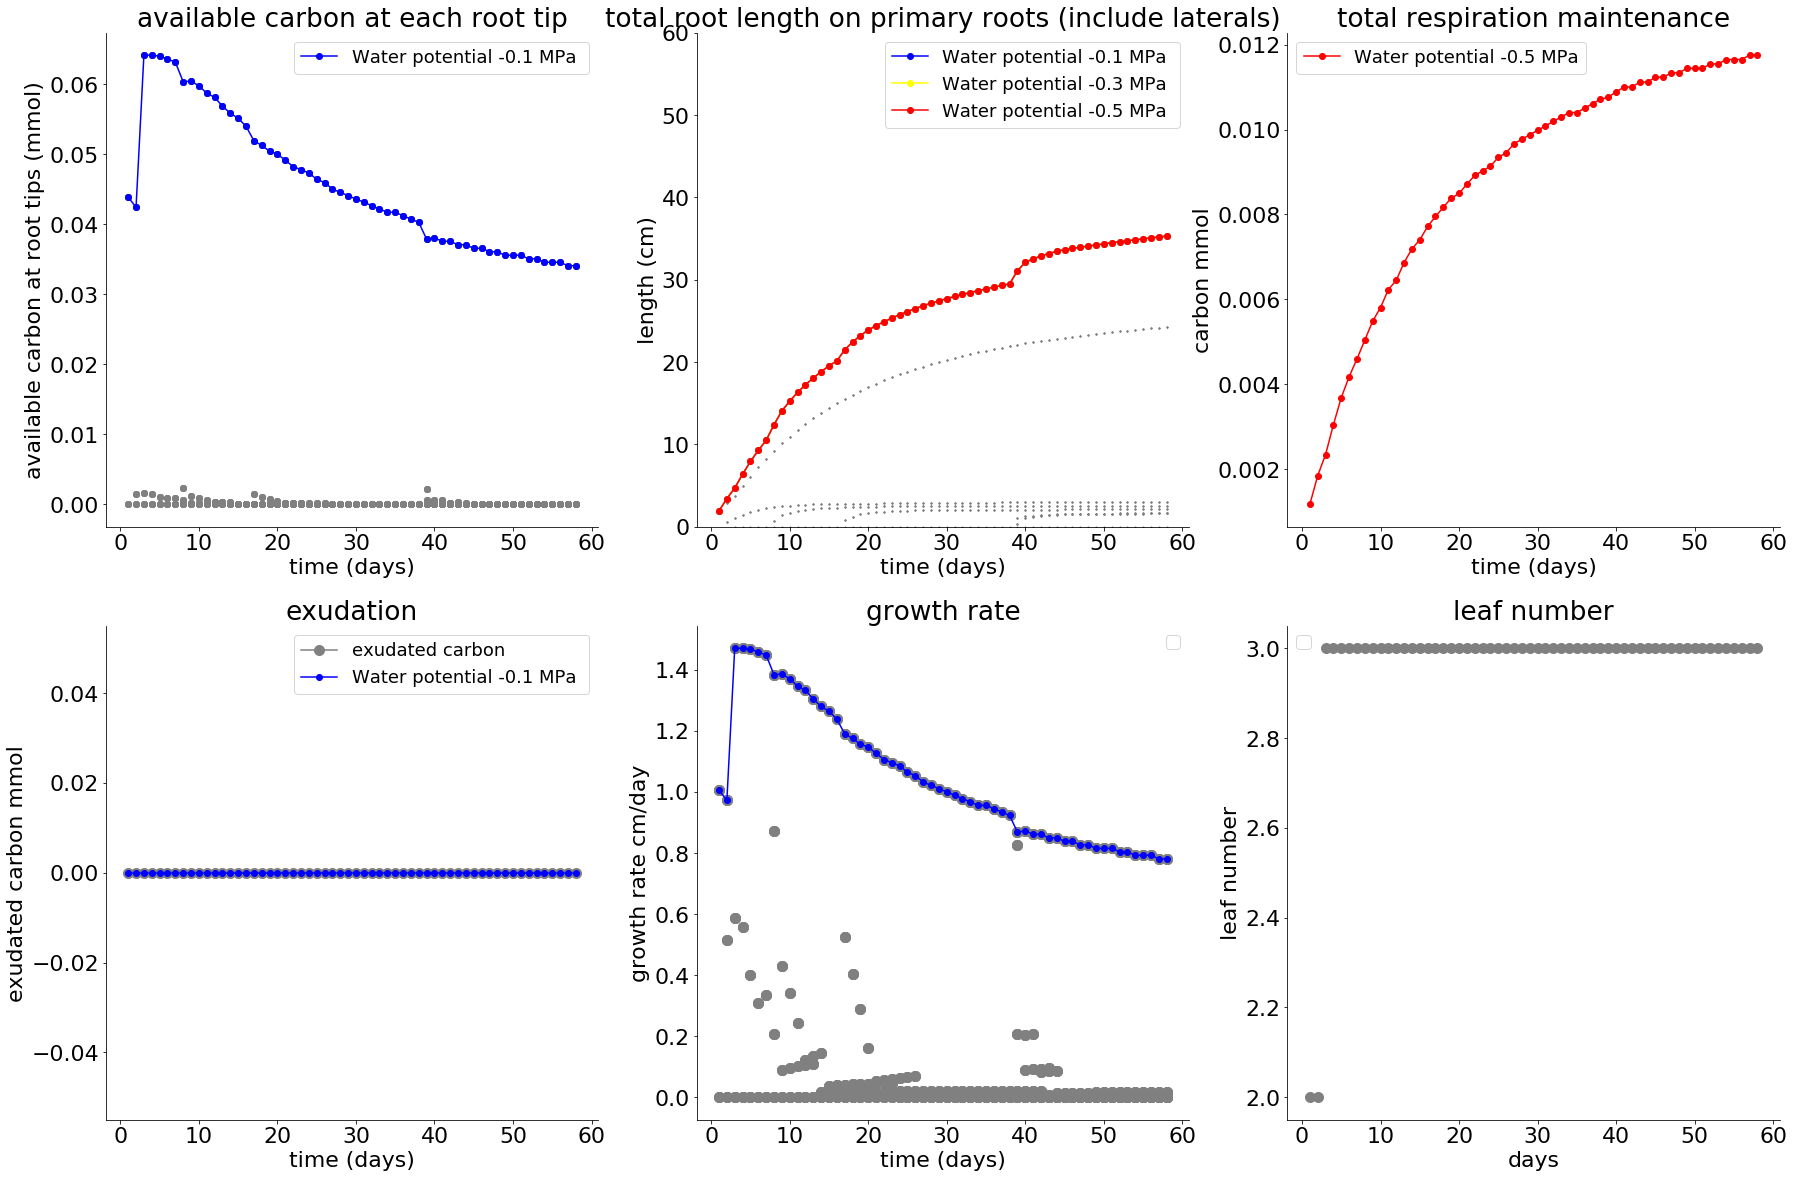

In [24]:
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(30,20))
a = 2
b = 3
def f2(x):
    return x #/12*1000  *0.1*0.2*0.12566370400000001

def f1(x):
    # return multiply *4200*24
    return x #*4200*24

root_1_l_cf = [] # root length 
root_1_c_cf = [] # available carbon
root_2_l_cf = []
root_2_c_cf = []
root_3_l_cf = []
root_3_c_cf = []


root_1_c_ec = [] # exudated carbon
root_2_c_ec = []
root_3_c_ec = []

root_1_c_gr = [] # growth rate
root_2_c_gr = []
root_3_c_gr = []

root_1_c_rr = [] #
root_2_c_rr = []
root_3_c_rr = []


growth_rate_logger 
exudation_logger 

for i, length_i in enumerate(root_he_l3):
    root_1_l_cf.append(length_i[np.array(root_he_l3[i]).nonzero()[0][0]])
    root_2_l_cf.append(length_i[np.array(root_he_l3[i]).nonzero()[0][1]])
    root_3_l_cf.append(length_i[np.array(root_he_l3[i]).nonzero()[0][2]])
    root_1_c_cf.append(root_he_c3[i][np.array(root_he_l3[i]).nonzero()[0][0]])
    root_2_c_cf.append(root_he_c3[i][np.array(root_he_l3[i]).nonzero()[0][1]])
    root_3_c_cf.append(root_he_c3[i][np.array(root_he_l3[i]).nonzero()[0][2]])
    
    root_1_c_gr.append(growth_rate_logger[i][np.array(root_he_l3[i]).nonzero()[0][0]])
    root_2_c_gr.append(growth_rate_logger[i][np.array(root_he_l3[i]).nonzero()[0][1]])
    root_3_c_gr.append(growth_rate_logger[i][np.array(root_he_l3[i]).nonzero()[0][2]])
    
    root_1_c_ec.append(exudation_logger[i][np.array(root_he_l3[i]).nonzero()[0][0]])
    root_2_c_ec.append(exudation_logger[i][np.array(root_he_l3[i]).nonzero()[0][1]])
    root_3_c_ec.append(exudation_logger[i][np.array(root_he_l3[i]).nonzero()[0][2]])
    
    root_1_c_rr.append(all_length_logger[i][np.array(root_he_l3[i]).nonzero()[0][0]])
    root_2_c_rr.append(all_length_logger[i][np.array(root_he_l3[i]).nonzero()[0][1]])
    root_3_c_rr.append(all_length_logger[i][np.array(root_he_l3[i]).nonzero()[0][2]])
    
ax1 = fig.add_subplot(a, b, 1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("available carbon at root tips (mmol)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
days = range(1,len(root_he_c3 )+1)
ax1.plot(days,f1(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)
# ax1.plot(days,f1(np.array(root_3_c_cf)), marker = "o", linestyle="-", color = "red", label= "Water potential -0.5 MPa ", zorder=2)
for i, day in enumerate(carbon_logger):
    x = [i+1]*len(day)
    ax1.plot(x,f1(np.array(carbon_logger[i])), marker = "o", linestyle="", color = "grey", zorder=1)
ax1.title.set_text("available carbon at each root tip")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()


ccc = np.squeeze(np.array(all_length_logger))
ax2 = fig.add_subplot(a, b, 2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
ax2.plot(days, root_2_l_cf, color= "yellow", marker = "o", label= "Water potential -0.3 MPa ")
ax2.plot(days, root_3_l_cf, color= "red", marker = "o", label= "Water potential -0.5 MPa")
for i, day in enumerate(all_length_logger):
    x = [i+1]*len(day)
    ax2.plot(x,day, marker = "o", linestyle="", color = "grey", zorder=1, markersize=1)
ax2.legend()
ax2.title.set_text("total root length on primary roots (include laterals)")
ax2.set_xlabel("time (days)")
ax2.set_ylabel("length (cm)")
ax2.set_ylim([0,60])
#ax2.set_xlim([0,120])
fig.savefig(fname= 'length2 ')





ax3 = fig.add_subplot(a, b, 3)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")

ax3.plot(days, f1(np.array(k1_logger)), color= "red", marker = "o", label= "Water potential -0.5 MPa")
ax3.legend()
ax3.title.set_text("total respiration maintenance")
ax3.set_xlabel("time (days)")
ax3.set_ylabel("carbon mmol")
#ax3.set_ylim([0,60])
#ax3.set_xlim([0,120])
fig.savefig(fname= 'length2 ')

total_exudation = []
for i, root_tip in enumerate(exudation_logger):
    total_exudation.append(np.sum(root_tip))

ax4 = fig.add_subplot(a, b, 4)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")

# for i, root_tip in enumerate(exudation_logger):
#     x = [i+1]*len(root_tip)
ax4.plot(days,total_exudation , marker = "o", linestyle="-", color = "grey", zorder=1, markersize=10, label = "exudated carbon")
ax4.plot(days,np.array(root_1_c_ec), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
# ax4.plot(days,np.array(root_2_c_ec), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)
# ax4.plot(days,np.array(root_3_c_ec), marker = "o", linestyle="-", color = "red", label= "Water potential -0.5 MPa ", zorder=2)

ax4.legend()
ax4.title.set_text("exudation")
ax4.set_xlabel("time (days)")
ax4.set_ylabel("exudated carbon mmol")
# ax4.set_ylim([0,10])
#ax4.set_xlim([0,120])
fig.savefig(fname= 'length2 ')


for i, root_tip in enumerate(exudation_logger):
    total_exudation.append(np.sum(root_tip))

ax5 = fig.add_subplot(a, b, 5)
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")

for i, root_tip in enumerate(growth_rate_logger):
    x = [i+1]*len(root_tip)
    ax5.plot(x,root_tip , marker = "o", linestyle="", color = "grey", zorder=1, markersize=10)
ax5.legend()
ax5.title.set_text("growth rate")
ax5.set_xlabel("time (days)")
ax5.set_ylabel("growth rate cm/day")
# ax5.set_ylim([0,10])
#ax4.set_xlim([0,120])

ax5.plot(days,np.array(root_1_c_gr), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
# ax5.plot(days,np.array(root_2_c_gr), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)
# ax5.plot(days,np.array(root_3_c_gr), marker = "o", linestyle="-", color = "red", label= "Water potential -0.5 MPa ", zorder=2)


ax6 = fig.add_subplot(a, b, 6)
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")

ax6.plot(days,leaf_logger , marker = "o", linestyle="", color = "grey", zorder=1, markersize=10)
ax6.legend()
ax6.title.set_text("leaf number")
ax6.set_xlabel("days")
ax6.set_ylabel("leaf number")
# ax5.set_ylim([0,10])
#ax4.set_xlim([0,120])
fig.savefig(fname= 'length2 ')

In [18]:
pd_output.to_csv("0.1water_desktop.csv", index=False)
op_01 = pd.read_csv("0.1water_desktop.csv")
# op_08 = pd.read_csv("all0.8.csv")


In [ ]:
column_name

In [5]:
# remove all non
def read_filter(file_name):
    op_01 = pd.read_csv(file_name)
    gr_column = ["time", "order", "growth_rate"]
    op_01_gr = op_01[op_01["growth_rate"].notna()]
    op_01_gr =  op_01_gr[gr_column]


    ca_column = ["time", "order", "carbon_q"]
    op_01_ca = op_01[op_01["growth_rate"].notna()]
    op_01_ca =  op_01_ca[ca_column]

    len_column = ["time", "order", "organ_length"]
    op_01_len = op_01[op_01["growth_rate"].notna()]
    op_01_len =  op_01_len[len_column]
    
    len_column = ["time", "order", "exudation"]
    op_01_ex = op_01[op_01["growth_rate"].notna()]
    op_01_ex =  op_01_ex[len_column]
    df = {"growth": op_01_gr, "carbon": op_01_ca, "length": op_01_len, "exudation":op_01_ex }
    return df
df01 = read_filter("0.1water_desktop.csv")
df08 = read_filter("0.8water_desktop.csv")
df15 = read_filter("1.5water_desktop.csv")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


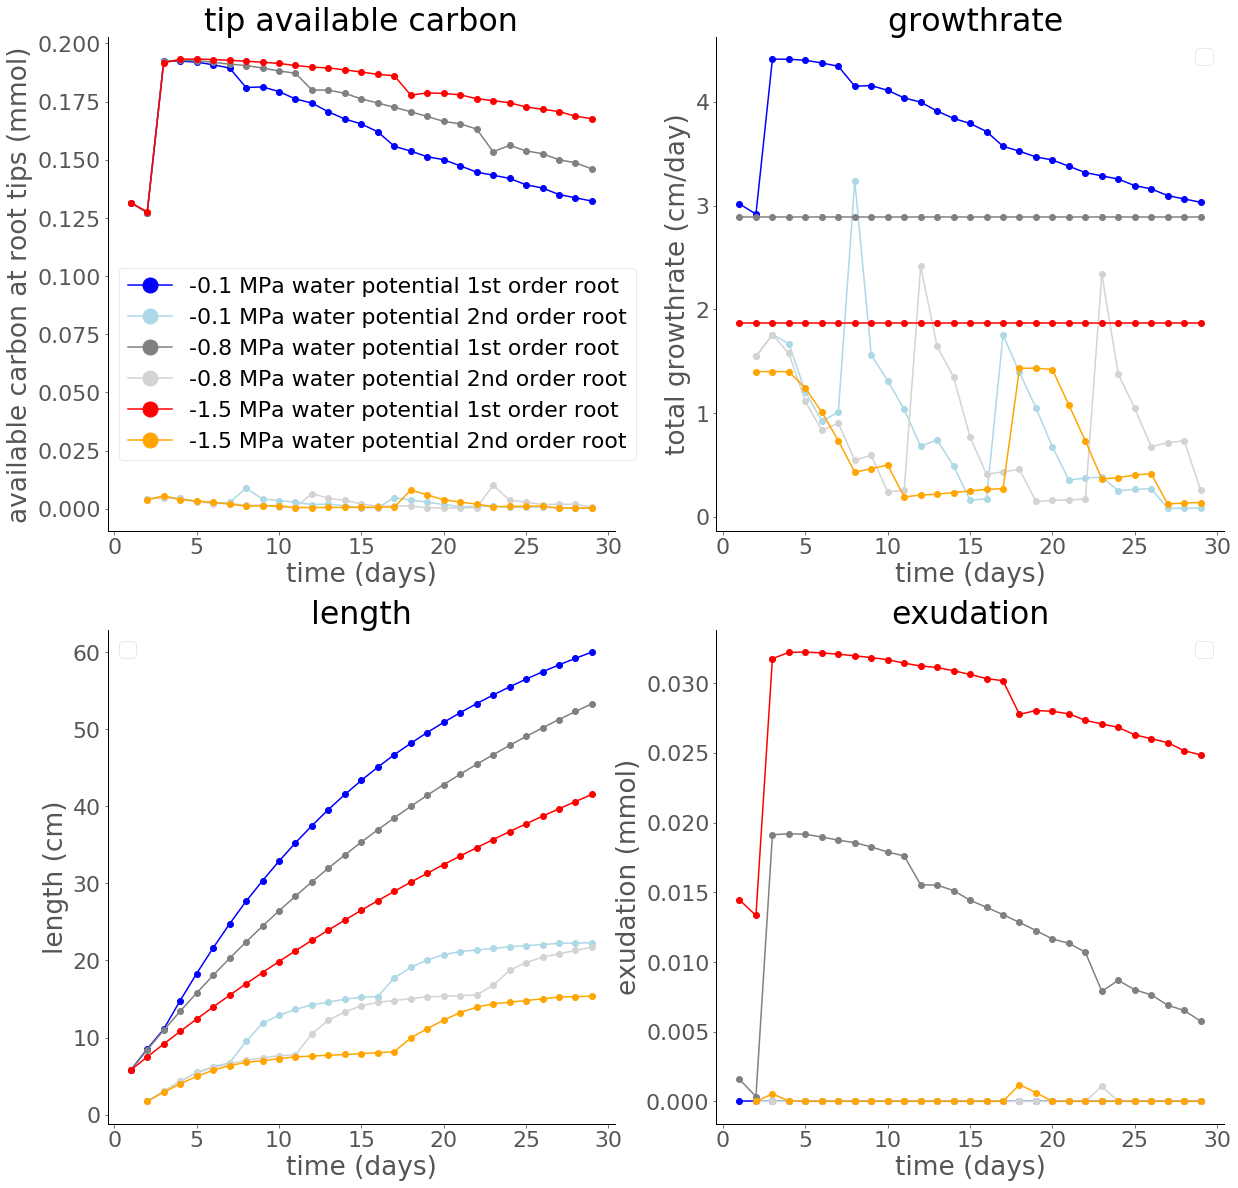

In [46]:

# remove all non


from cycler import cycler
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(20,20))


plt.rc('axes', prop_cycle=(cycler('color', ['blue', 'lightblue', 'grey','lightgrey', 'red','orange'])))

a = 2
b = 2


ax1 = fig.add_subplot(a, b, 1)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("available carbon at root tips (mmol)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("tip available carbon")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

ax1.plot(df01["carbon"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08["carbon"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15["carbon"].groupby(['time',"order"]).sum().unstack(),marker= "o")

blue_line = mlines.Line2D([], [], color='blue', marker='o',
                          markersize=15, label='-0.1 MPa water potential 1st order root')
lightblue_line = mlines.Line2D([], [], color='lightblue', marker='o',
                          markersize=15, label='-0.1 MPa water potential 2nd order root')
grey_line = mlines.Line2D([], [], color='grey', marker='o',
                          markersize=15, label='-0.8 MPa water potential 1st order root')
lightgrey_line = mlines.Line2D([], [], color='lightgrey', marker='o',
                          markersize=15, label='-0.8 MPa water potential 2nd order root')
red_line = mlines.Line2D([], [], color='red', marker='o',
                          markersize=15, label='-1.5 MPa water potential 1st order root')
orange_line = mlines.Line2D([], [], color='orange', marker='o',
                          markersize=15, label='-1.5 MPa water potential 2nd order root')

plt.legend(loc='lower left', bbox_to_anchor=(0, 0.12, 0, 0), handles=[blue_line, lightblue_line, grey_line, lightgrey_line, red_line, orange_line])















ax1 = fig.add_subplot(a, b, 2)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("total growthrate (cm/day)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text(" growthrate")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.plot(df01["growth"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08["growth"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15["growth"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.legend()










ax1 = fig.add_subplot(a, b, 3)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("length (cm)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("length")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

ax1.plot(df01["length"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08["length"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15["length"].groupby(['time',"order"]).sum().unstack(),marker= "o")

ax1 = fig.add_subplot(a, b, 4)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("exudation (mmol)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("exudation")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

fig_colum_name = "exudation"



ax1.plot(df01[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")


In [75]:
# remove all non
def read_filter(file_name):
    op_01 = pd.read_csv(file_name)
    gr_column = ["time", "order", "growth_rate"]
    op_01_gr = op_01[op_01["growth_rate"].notna()]
    op_01_gr =  op_01_gr[gr_column]


    ca_column = ["time", "order", "carbon_q"]
    op_01_ca = op_01[op_01["growth_rate"].notna()]
    op_01_ca =  op_01_ca[ca_column]

    len_column = ["time", "order", "organ_length"]
    op_01_len = op_01[op_01["growth_rate"].notna()]
    op_01_len =  op_01_len[len_column]
    
    len_column = ["time", "order", "exudation"]
    op_01_ex = op_01[op_01["growth_rate"].notna()]
    op_01_ex =  op_01_ex[len_column]
    df = {"growth": op_01_gr, "carbon": op_01_ca, "length": op_01_len, "exudation":op_01_ex }
    return df
df01 = read_filter("0.1water_desktop.csv")
df08 = read_filter("0.8water_desktop.csv")
df15 = read_filter("1.5water_desktop.csv")



In [70]:
fig_colum_name ="length"
df01 = df01[fig_colum_name]
df01 = df01[df01.order.eq(1)]

fig_colum_name ="length"
df08 = df08[fig_colum_name]
df08 = df08[df08.order.eq(1)]

fig_colum_name ="length"
df15 = df15[fig_colum_name]
df15 = df15[df15.order.eq(1)]

In [79]:
df15["length"]

,time,order,organ_length
8,1,1,1.927722
16,1,1,1.927722
24,1,1,1.927722
72,2,2,0.578588
74,2,1,2.498565
77,2,2,0.578588
79,2,1,2.498565
82,2,2,0.578588
84,2,1,2.498565
149,3,2,0.972350


No handles with labels found to put in legend.


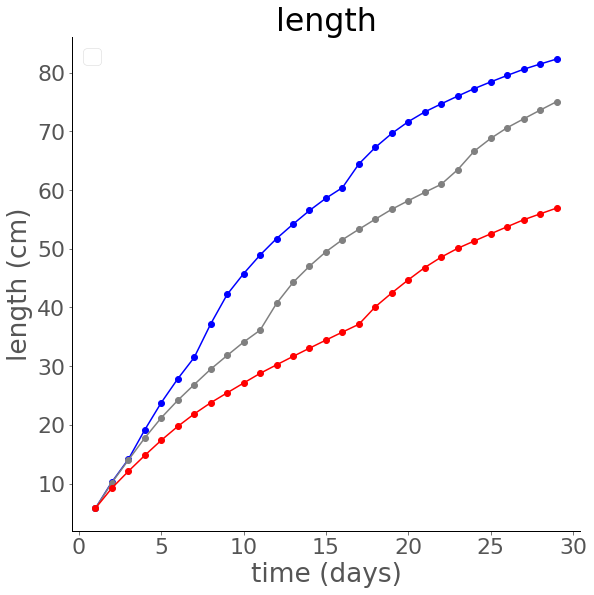

In [97]:


from cycler import cycler
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(20,20))
plt.rc('axes', prop_cycle=(cycler('color', ['blue', 'grey', 'red'])))
ax1 = fig.add_subplot(a, b, 3)



ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("length (cm)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("length")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

ax1.plot(df01["length"][['organ_length', 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df08["length"][['organ_length', 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df15["length"][['organ_length', 'time']].groupby(['time']).sum(),marker= "o")

In [94]:
df01["length"][['organ_length', 'time']]

,organ_length,time
8,1.927722,1
16,1.927722,1
24,1.927722,1
72,0.578588,2
76,2.843896,2
79,0.578588,2
83,2.843896,2
86,0.578588,2
90,2.843896,2
162,1.011361,3


In [30]:

# remove all non


from cycler import cycler
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(20,20))


plt.rc('axes', prop_cycle=(cycler('color', ['blue', 'lightblue', 'grey','lightgrey', 'red','orange'])))

a = 2
b = 2


ax1 = fig.add_subplot(a, b, 1)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("available carbon at root tips (mmol)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("tip available carbon")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

ax1.plot(df01.groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08["carbon"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15["carbon"].groupby(['time',"order"]).sum().unstack(),marker= "o")

blue_line = mlines.Line2D([], [], color='blue', marker='o',
                          markersize=15, label='-0.1 MPa water potential 1st order root')
lightblue_line = mlines.Line2D([], [], color='lightblue', marker='o',
                          markersize=15, label='-0.1 MPa water potential 2nd order root')
grey_line = mlines.Line2D([], [], color='grey', marker='o',
                          markersize=15, label='-0.8 MPa water potential 1st order root')
lightgrey_line = mlines.Line2D([], [], color='lightgrey', marker='o',
                          markersize=15, label='-0.8 MPa water potential 2nd order root')
red_line = mlines.Line2D([], [], color='red', marker='o',
                          markersize=15, label='-1.5 MPa water potential 1st order root')
orange_line = mlines.Line2D([], [], color='orange', marker='o',
                          markersize=15, label='-1.5 MPa water potential 2nd order root')

plt.legend(loc='lower left', bbox_to_anchor=(0, 0.12, 0, 0), handles=[blue_line, lightblue_line, grey_line, lightgrey_line, red_line, orange_line])















ax1 = fig.add_subplot(a, b, 2)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("total growthrate (cm/day)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text(" growthrate")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.plot(df01["growth"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08["growth"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15["growth"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.legend()










ax1 = fig.add_subplot(a, b, 3)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("length (cm)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("length")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

ax1.plot(df01["length"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08["length"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15["length"].groupby(['time',"order"]).sum().unstack(),marker= "o")

ax1 = fig.add_subplot(a, b, 4)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("exudation (mmol)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("exudation")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

fig_colum_name = "exudation"



ax1.plot(df01[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")

No handles with labels found to put in legend.


KeyError: 'sub_type'

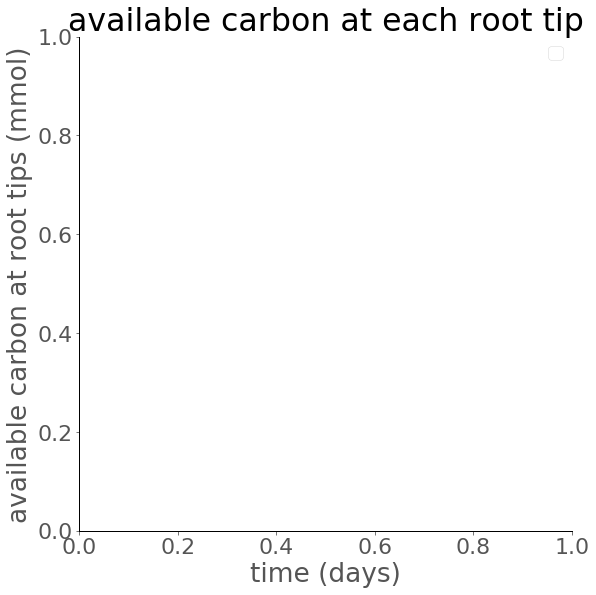

In [57]:
import matplotlib
matplotlib.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(30,20))




a = 2
b = 3
    
ax1 = fig.add_subplot(a, b, 1)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("available carbon at root tips (mmol)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("available carbon at each root tip")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

ax1.plot(op_01_ca.groupby(['time','sub_type']).sum().unstack())



ax1 = fig.add_subplot(a, b, 2)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("available carbon at root tips (mmol)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("available carbon at each root tip")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

ax1.plot(op_01_gr.groupby(['time','sub_type']).sum().unstack(), marker= "o")


ax1 = fig.add_subplot(a, b, 3)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("length")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("length")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

ax1.plot(op_01_len.groupby(['time','sub_type']).sum().unstack(), marker= "o")

In [ ]:
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(30,20))


a = 2
b = 3
    
ax1 = fig.add_subplot(a, b, 1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("available carbon at root tips (mmol)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)
ax1.plot(days,f1(np.array(root_3_c_cf)), marker = "o", linestyle="-", color = "red", label= "Water potential -0.5 MPa ", zorder=2)
for i, day in enumerate(carbon_logger):
    x = [i+1]*len(day)
    ax1.plot(x,f1(np.array(carbon_logger[i])), marker = "o", linestyle="", color = "grey", zorder=1)
ax1.title.set_text("available carbon at each root tip")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()


ccc = np.squeeze(np.array(all_length_logger))
ax2 = fig.add_subplot(a, b, 2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
ax2.plot(days, root_2_l_cf, color= "yellow", marker = "o", label= "Water potential -0.3 MPa ")
ax2.plot(days, root_3_l_cf, color= "red", marker = "o", label= "Water potential -0.5 MPa")
for i, day in enumerate(all_length_logger):
    x = [i+1]*len(day)
    ax2.plot(x,day, marker = "o", linestyle="", color = "grey", zorder=1, markersize=1)
ax2.legend()
ax2.title.set_text("total root length on primary roots (include laterals)")
ax2.set_xlabel("time (days)")
ax2.set_ylabel("length (cm)")
ax2.set_ylim([0,60])
#ax2.set_xlim([0,120])
fig.savefig(fname= 'length2 ')





ax3 = fig.add_subplot(a, b, 3)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")

ax3.plot(days, f1(np.array(k1_logger)), color= "red", marker = "o", label= "Water potential -0.5 MPa")
ax3.legend()
ax3.title.set_text("total respiration maintenance")
ax3.set_xlabel("time (days)")
ax3.set_ylabel("carbon mmol")
#ax3.set_ylim([0,60])
#ax3.set_xlim([0,120])
fig.savefig(fname= 'length2 ')

total_exudation = []
for i, root_tip in enumerate(exudation_logger):
    total_exudation.append(np.sum(root_tip))

ax4 = fig.add_subplot(a, b, 4)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")

# for i, root_tip in enumerate(exudation_logger):
#     x = [i+1]*len(root_tip)
ax4.plot(days,total_exudation , marker = "o", linestyle="-", color = "grey", zorder=1, markersize=10, label = "exudated carbon")
#ax4.plot(days,np.array(root_1_c_ec), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax4.plot(days,np.array(root_2_c_ec), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)
ax4.plot(days,np.array(root_3_c_ec), marker = "o", linestyle="-", color = "red", label= "Water potential -0.5 MPa ", zorder=2)

ax4.legend()
ax4.title.set_text("exudation")
ax4.set_xlabel("time (days)")
ax4.set_ylabel("exudated carbon mmol")
# ax4.set_ylim([0,10])
#ax4.set_xlim([0,120])
fig.savefig(fname= 'length2 ')


for i, root_tip in enumerate(exudation_logger):
    total_exudation.append(np.sum(root_tip))

ax5 = fig.add_subplot(a, b, 5)
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")

for i, root_tip in enumerate(growth_rate_logger):
    x = [i+1]*len(root_tip)
    ax5.plot(x,root_tip , marker = "o", linestyle="", color = "grey", zorder=1, markersize=10)
ax5.legend()
ax5.title.set_text("growth rate")
ax5.set_xlabel("time (days)")
ax5.set_ylabel("growth rate cm/day")
# ax5.set_ylim([0,10])
#ax4.set_xlim([0,120])

ax5.plot(days,np.array(root_1_c_gr), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
ax5.plot(days,np.array(root_2_c_gr), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)
ax5.plot(days,np.array(root_3_c_gr), marker = "o", linestyle="-", color = "red", label= "Water potential -0.5 MPa ", zorder=2)


ax6 = fig.add_subplot(a, b, 6)
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")

ax6.plot(days,leaf_logger , marker = "o", linestyle="", color = "grey", zorder=1, markersize=10)
ax6.legend()
ax6.title.set_text("leaf number")
ax6.set_xlabel("days")
ax6.set_ylabel("leaf number")
# ax5.set_ylim([0,10])
#ax4.set_xlim([0,120])
fig.savefig(fname= 'length2 ')

In [ ]:
root_he_l3

In [ ]:
list(axial_r_xylem_0_25cm)

##Length of each connection

The connections are stored in *node_connection* list. Every element of the list is a two number list. The first element of this two numbered list is the first connected node and the second element of this two numbered list is the second connected node.

In [ ]:
pd_output

In [ ]:
(nodes_coor[np.amax(node_connection[i])-1][3]-nodes_coor[np.amin(node_connection[i])-1][3])**2 

In [ ]:
node_c_length=[]
node_c_length = [0] * (len(node_connection) +1)

In [ ]:
i=0
for i, connection in enumerate(node_connection):
    node_c_length[i+1] = node_c_length[np.amin(node_connection[i])-1] + ((nodes_coor[np.amax(node_connection[i])-1][3]-nodes_coor[np.amin(node_connection[i])-1][3])**2 + (nodes_coor[np.amax(node_connection[i])-1][4]-nodes_coor[np.amin(node_connection[i])-1][4])**2 + (nodes_coor[np.amax(node_connection[i])-1][5]-nodes_coor[np.amin(node_connection[i])-1][5])**2)**(0.5) 


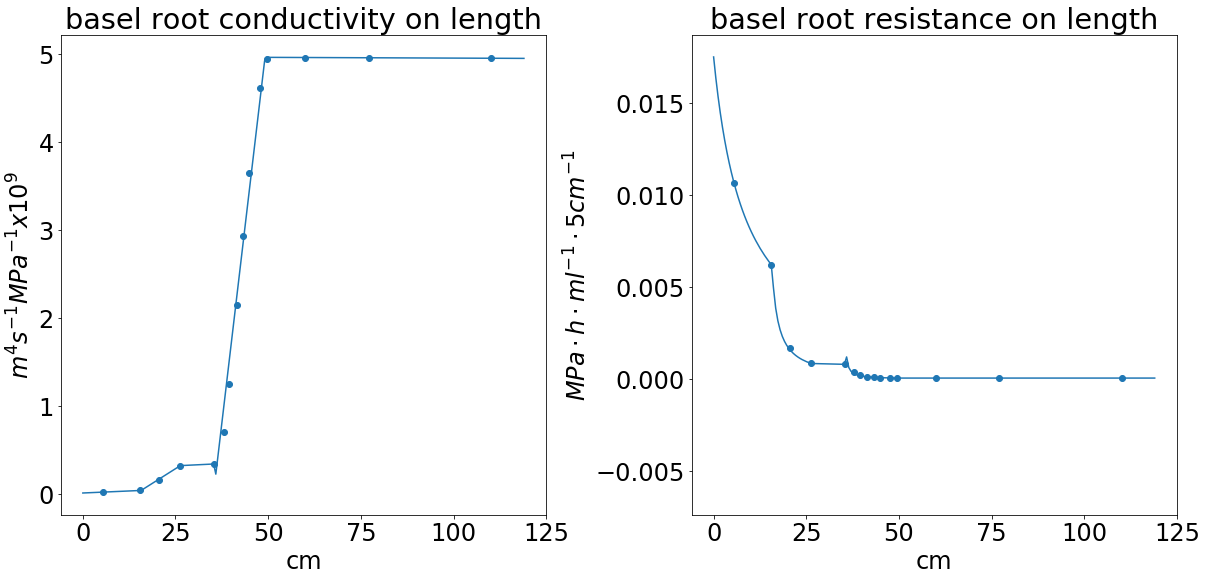

In [4]:
plt.rcParams['figure.figsize'] = [20, 30]
plt.rcParams.update({'font.size': 24})
f = plt.figure()
plt.rcParams.update({'legend.fontsize': 18})
f.subplots_adjust(wspace=0.3)

x_axis_cm = [
5.506136884, 
15.55448305, 
20.57316414, 
26.18098606,
35.34262534,
37.98477221,
39.43565633,
41.46070314,
43.19517371,
44.93363844,
47.69361348,
49.59883503,
59.94275016,
77.08574995,
110.1894737,]

y_axis_r_primary = [
0.02602038694,
0.04459330144,
0.1653671729,
0.3265820678,
0.3453047639,
0.7097233202,
1.256775536,
2.148325359,
2.938572914,
3.647738714,
4.620245475,
4.944247972,
4.962770959,
4.959875182,
4.954283337,  
]

ax = plt.subplot(321)

ax.scatter(x_axis_cm, y_axis_r_primary)
# primary_r_interval = [0, 15, 35, ] 
def k_primary(x):
    if x < 15.55:
        return 0.001848355360491469*x+0.015843089314858807
    elif 26.18> x >= 15.55 :
        return 0.0265794629572805*x-0.3731958224157048
    elif 35.34> x >= 26.18 :
        return 0.0020435967328327315*x +0.2730786902254447
    elif 49.59> x >= 35.34 :
        return 0.35677667926196793*x -12.57081093520535
    elif 120> x >= 49.59 :
        return -0.00016891891420869065*x +4.9728964232362864 


ax.title.set_text("basel root conductivity on length")
ax.set_xlabel("cm")
ax.set_ylabel("$m^4 s^{-1} MPa^{-1} x 10^9$")

#     from conductivity to resistance from m^4 s^-1 MPa^-1 x 10^9  to  MPa h ml^-1 /5 cm
def k_to_r(k): 
    return 10e-9 *100*100*100*100 /3600/k
    
x = np.linspace(0,119,200)
y = np.zeros(200)
for i in range (0,len(x)):
    y[i] = k_primary(x[i])

ax.plot(x, y)


ax = plt.subplot(322)

yc2 = np.zeros(len(x_axis_cm))
for i in range (0,len(x_axis_cm)):
    yc2[i] = k_to_r(y_axis_r_primary[i])

ax.scatter(x_axis_cm,yc2)
x = np.linspace(0,119,200)
y2 = np.zeros(200)
for i in range (0,len(x)):
    y2[i] = k_to_r((k_primary(x[i])))
    

ax.title.set_text("basel root resistance on length")
ax.set_xlabel("cm")
ax.set_ylabel("$MPa \cdot h \cdot ml^{-1} \cdot 5cm^{-1}$")    
    
ax.plot(x, y2)

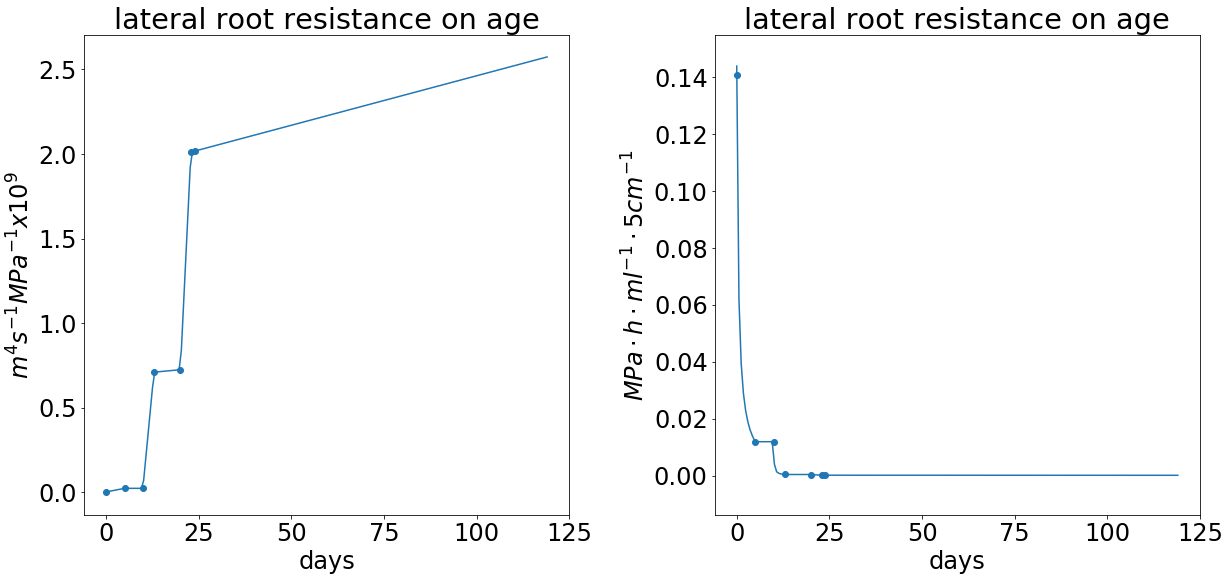

In [5]:
plt.rcParams['figure.figsize'] = [20, 30]
plt.rcParams.update({'font.size': 24})
f = plt.figure()
plt.rcParams.update({'legend.fontsize': 18})
f.subplots_adjust(wspace=0.3)

x_axis_day = [
0.009810055459,
5.020713492,
9.963766575,
12.95495271,
20.08446367,
22.92530994,
23.92745418,]

y_axis_r_lateral = [
0.001971122598,
0.0233102711,
0.02327989941,
0.710208532,
0.7246776045,
2.011526056,
2.017393866,  
]

ax = plt.subplot(321)

ax.scatter(x_axis_day, y_axis_r_lateral)
# primary_r_interval = [0, 15, 35, ] 
def k_lateral(x):
    if x < 5:
        return 0.004258543149115853*x+0.0019293460538895271
    elif  9.96> x >= 5:
        return 0.0000019478470310608697*x+0.02330049151582271
    elif 12.95> x >= 9.96 :
        return 0.22965091485084213*x -2.2649082099802036
    elif 20> x >= 12.95 :
        return 0.0020294621328947786*x + 0.6839169460538098
    elif 23> x >= 20 :
        return 0.45298067054396246*x +-8.373196214574355 
    elif  x >= 23 :
        return 0.005855255182446519*x +1.877292516018327

#     from conductivity to resistance from m^4 s^-1 MPa^-1 x 10^9  to  MPa h ml^-1 /5 cm
def k_to_r(k): 
    return 10e-9 *100*100*100*100 /3600/k
    
x = np.linspace(0,119,200)
y = np.zeros(200)
for i in range (0,len(x)):
    y[i] = k_lateral(x[i])

ax.title.set_text("lateral root resistance on age")
ax.set_xlabel("days")
ax.set_ylabel("$m^4 s^{-1} MPa^{-1} x 10^9$")
    
ax.plot(x, y)


ax = plt.subplot(322)

yc2 = np.zeros(len(x_axis_day))
for i in range (0,len(x_axis_day)):
    yc2[i] = k_to_r(y_axis_r_lateral[i])

ax.scatter(x_axis_day,yc2)
x = np.linspace(0,119,200)
y2 = np.zeros(200)
for i in range (0,len(x)):
    y2[i] = k_to_r((k_lateral(x[i])))

ax.title.set_text("lateral root resistance on age")
ax.set_xlabel("days")
ax.set_ylabel("$MPa \cdot h \cdot ml^{-1} \cdot 5cm^{-1}$")    
    
    
ax.plot(x, y2)

In [ ]:
y

In [ ]:
nodes_length = np.zeros(len(nodes_coor))
for i in range(1,len(nodes_coor)):
    if nodes_coor[i][1]==2: #if the organtype is root
        nodes_length[i] = nodes_length[node_connection_o[(node_connection_o[:,1] == i)][0][0]] - ((nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][3]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][3])**2 + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][4]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][4])**2 + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][5]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][5])**2)**(0.5) 
    else:
        nodes_length[i] = nodes_length[node_connection_o[(node_connection_o[:,1] == i)][0][0]] + ((nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][3]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][3])**2 + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][4]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][4])**2 + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][5]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][5])**2)**(0.5) 


In [ ]:
1

In [ ]:
for i, node_l in enumerate(nodes_length):
#     print(plant.getOrgans()[node_id_to_organ[i]].getOrganRandomParameter().subType)
    phloem_radius = plant.getOrgans()[node_id_to_organ[i]].getOrganRandomParameter().r
    resistance_propotional =20 *(2**4)/phloem_radius**4 # based on hagen poissuelle's law
    print(plant.getOrgans()[node_id_to_organ[i]].getOrganRandomParameter().r)
    

In [ ]:
for i in range(0,(len(node_connection)+1)):    
    print(plant.getOrgans()[node_id_to_organ[i]].getLength()/100) 

In [ ]:
axial_r_xylem = []
for i in range(0,(len(node_connection))):
    if plant.getOrgans()[node_id_to_organ[i+1]].getParent().getOrganRandomParameter().subType == 0:
        axial_r_xylem.append(
           k_to_r(k_primary(max(0 ,plant.getOrgans()[node_id_to_organ[i+1]].getLength() - np.abs(nodes_length[i+1])*100))))
    else:
        axial_r_xylem.append( k_to_r(k_lateral(plant.getSegmentCTs()[i])) )

In [ ]:
axial_r_xylem

In [ ]:
len(to_tip_distance)

In [ ]:
plant.getOrgans()[1].getChild(0).getAge()

In [ ]:
plant.getOrgans()[1].getChild(1).getAge()

In [ ]:
N1L_node

In [ ]:
all_marker_c = [] # all the marker for connections
N1L_connection = [] # all the marker for connections
N1R_connection = [] # all the marker for connections
for i,n in enumerate(N1R_node.T[0]):
    N1R_connection.append(np.where(node_connection[:,1] == N1R_node.T[0][i] )[0][0])
for i,n in enumerate(N1L_node.T[0]):
    N1L_connection.append(np.where(node_connection[:,0] == N1L_node.T[0][i] )[0][0])
all_marker_c.append(N1L_connection)

In [ ]:
for i in N1L_connection:
    print(node_connection[i][0])

In [ ]:
piaf_output["JS_ST"]

In [ ]:
len(piaf_output["JW_Xyl"][1])

In [ ]:
for i,n in enumerate(N1L_node.T[0]):
    print(np.where(node_connection[:,0] == N1L_node.T[0][i] )[0][0])

In [ ]:
dict_all["node_connection"]

In [ ]:
all_marker_c_1

In [ ]:
stem_mid_node

In [ ]:
def add_day_night():
    #trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    #ax.fill_between(x, np.min(y), np.max(y), where=[ 12<x<18] , facecolor='lightgrey', alpha=1, interpolate=False,zorder=0,transform=trans)
    for i in range(0,4):
        ax.axvspan(0,5,facecolor='lightgrey', zorder=0)
        ax.axvspan(18+24*i,29+24*i,facecolor='lightgrey',zorder=0)
        
plt.style.use('default')
x=piaf_output["time"]
lable_size=16
title_size =24

def line_style(int): #set line style in the plot figure
    if  i ==1 : #int is a small part of main stem which are shown in dashed line 
        return ':'
    else: #
        return '-'
stem_line = mlines.Line2D([], [], color='darkgreen', marker='', linestyle='-', linewidth= 5,
                          markersize=30, label='Stem')
root_line = mlines.Line2D([], [], color='wheat', marker='', linestyle='-', linewidth= 5,
                          markersize=30, label='Root')
leaf_line = mlines.Line2D([], [], color='lightgreen', marker='', linestyle='-', linewidth= 5,
                          markersize=30, label='Leaf')
stem_line1 = mlines.Line2D([], [], color='darkgreen', marker='', linestyle=':', linewidth= 5,
                          markersize=30, label='Stem\n between\n two\n leaves')


csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Comic Sans MS'}

plt.rcParams['figure.figsize'] = [20, 30]
plt.rcParams.update({'font.size': 24})
f = plt.figure()
plt.rcParams.update({'legend.fontsize': 18})
f.subplots_adjust(wspace=0.3)

node_connection =dict_all['node_connection']

stem_nodes = nodes_organtype[(nodes_organtype[:,1]== 2)][:,0] 
root_nodes = nodes_organtype[(nodes_organtype[:,1]== 1)][:,0] 
leaf_nodes = nodes_organtype[(nodes_organtype[:,1]== 3)][:,0] 
# get all the end nodes
for k in reversed(range(len(organ))):  # loop through all the organs
    if organ[k].organType()==3 and organ[k].getParent().organType()==1:
        stem_mid_node = organ[k].getNodeId(2)
all_marker = np.concatenate((N1L_node.T[0], N1R_node.T[0], [stem_mid_node]  ), axis=0, out=None).astype(int)
all_marker_1  = map(lambda x: x-1, all_marker)
all_marker_1 = list(all_marker_1)
#  =[3, 10, 17, 23,28, 31,]

all_marker_c = [] # all the marker for connections
for i,n in enumerate(N1R_node.T[0]):
    all_marker_c.append(np.where(node_connection[:,1] == N1R_node.T[0][i] )[0][0])
for i,n in enumerate(N1L_node.T[0]):
    all_marker_c.append(np.where(node_connection[:,0] == N1L_node.T[0][i] )[0][0])
all_marker_c.append(np.where(node_connection[:,1] == stem_mid_node)[0][0])

# all_marker_c_1  = map(lambda x: x-1, all_marker_c)
all_marker_c_1 = list(all_marker_c)
    
def organ_color_n(int):
    if int+1 in N1L_node.T[0]: #int is source 
        return 'lightgreen'
    elif int+1 in N1R_node.T[0] : #int is sink
        return 'wheat'
    elif int+1 == stem_mid_node :
        return 'darkgreen'
    else:
        return 'None'    

def organ_color_c(int):
    if node_connection[int,0] in N1L_node.T[0]: #int is source 
        return 'lightgreen'
    elif node_connection[int,1] in N1R_node.T[0] : #int is sink
        return 'wheat'
    elif  node_connection[int,1] == stem_mid_node :
        return 'darkgreen'
    else:
        return 'None'       
time = piaf_output["time"]

ax = plt.subplot(321)
ax.tick_params(width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
plt.xlabel("Time (hour)")
plt.ylabel("Xylem Pressure (MPa)", color='black')
#plt.ylabel("Xylem water flow (ml h$^{-1}$)".format(output.columns[n_begin]))
#plt.title("{}th figure {} ".format(i ,output.columns[n_begin]))
plt.title("A: Xylem Pressure", color='black' ,loc="left")
#plt.title("Xylem Water Flow with Constant Transpiration".format(i ,output.columns[n_begin]))
for i in all_marker_1:
    ax.plot(x,piaf_output["P_Xyl"].T[i], linewidth=5
                ,c=organ_color_n(i),alpha=0.8,zorder=0, ls = line_style(i))
add_day_night()








ax = plt.subplot(322)
ax.tick_params(width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
plt.xlabel("Time (hour)")
plt.ylabel("Xylem Water Flow (ml h$^{-1}$)")
plt.title("B: Xylem Water Flow",loc="left")
#plt.title("Xylem Water Flow with Constant Transpiration".format(i ,output.columns[n_begin]))
for i in all_marker_c_1:
    ax.plot(x,piaf_output["JW_Xyl"].T[i], linewidth=5,c=organ_color_c(i),alpha=0.8,zorder=0, ls = line_style(i))
# plt.ylim((-0.0001, 0.0005))
# plt.xlim((15, 32))
add_day_night()


ax = plt.subplot(323)
ax.tick_params(width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
plt.xlabel("Time (hour)", **hfont)
plt.ylabel('Water from Xylem to Phloem (ml h⁻¹)', color='black')
plt.title('C: Water from Xylem to Phloem', color='black', loc="left")  
for i in all_marker_1:
        ax.plot(x,piaf_output["JW_Trsv"].T[i], linewidth=5,
                c=organ_color_n(i),alpha=0.8, ls = line_style(i))
add_day_night()




ax = plt.subplot(324)
ax.tick_params(width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)


plt.xlabel("Time (hour)", **hfont)

plt.ylabel('Carbon Flow (mmol h⁻¹)', color='black')
 
plt.title('D: Phloem Carbon Flow', color='black',loc="left")  
for i in all_marker_c_1:
    ax.plot(x,piaf_output["JS_ST"].T[i], linewidth=5
                ,c=organ_color_c(i),alpha=0.8,zorder=0, ls = line_style(i))
add_day_night()


ax = plt.subplot(325)
ax.tick_params(width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)


plt.xlabel("Time (hour)", **hfont)

plt.ylabel('Phloem pressure (MPa)', color='black')
 
plt.title('E: Phloem pressure', color='black',loc="left")  
for i in all_marker_c_1:
    ax.plot(x,piaf_output["P_ST"].T[i], linewidth=5
                ,c=organ_color_c(i),alpha=0.8,zorder=0, ls = line_style(i))
add_day_night()

ax = plt.subplot(326)
ax.tick_params(width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)


plt.xlabel("Time (hour)", **hfont)

plt.ylabel('Phloem Flow (ml h⁻¹)', color='black')
 
plt.title('E: Phloem Flow', color='black',loc="left")  
for i in all_marker_c_1:
    ax.plot(x,piaf_output["JW_ST"].T[i], linewidth=5
                ,c=organ_color_c(i),alpha=0.8,zorder=0, ls = line_style(i))
add_day_night()

plt.show()
# s =output.columns[n_begin]
# s = s.replace('/', '')
s = "small_2020"
# f.savefig("diural_homogeneous{}.png".format(s), bbox_inches='tight', dpi=600)



In [ ]:
# castor beans phloem flow rate: 0.2 (mm^3 s^-1)*3600/1000 = 0.72 ml/h doi: 10.1111/j.1365-3040.2006.01544.x
# castor beans Xylem flow rate: 4 (mm^3 s^-1) *3600/1000 = 14.5

In [ ]:
nodes_coor

In [ ]:

# nodes_coor = np.column_stack([dict_all["nodes_organtype"], dict_all["nodes"]])
nodes_coor = python_nodes(plant)
node_connection = dict_all["node_connection"]
plt.rcParams['figure.figsize'] = [20, 20]

import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt




fig = plt.figure()

ax = fig.add_subplot(122, projection='3d')
plt.rcParams.update({'font.size': 90})
plt.title('PiafMünch')
x =nodes_coor[:,3]*100
y =nodes_coor[:,4]*100
z =nodes_coor[:,5]*100

# Get rid of colored axes planes
# First remove fill
#ax.set_axis_off()
# Get rid of the panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Get rid of the spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Now set color to white (or whatever is "invisible")
#ax.xaxis.pane.set_edgecolor('w')
#ax.yaxis.pane.set_edgecolor('w')
#ax.zaxis.pane.set_edgecolor('w')


ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_zticks([])

# Bonus: To get rid of the grid as well:
ax.grid(False)

def so_si_color(int):
    if int in N1L_node[:,0]: #int is source 
        return 'lightgreen'
    elif int in N1R_node[:,0]: #int is sink
        return 'orange'
    else:
        return 'darkgreen'
    


for i in range(len(nodes_coor)):
    ax.plot([x[i]], [y[i]], [z[i]], marker='${}$'.format(i),
            markersize=20, color=so_si_color(i+1), alpha=1)
    #ax.scatter(cor_x[i], cor_y[i],cor_z[i], s=100, marker = organ_marker(node_connection[i,0]) ,edgecolors= organ_color3(i))

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.set_xlim3d(-1.2, 1)
ax.set_ylim3d(1.5 ,0.5)
ax.set_zlim3d(-8.8,0)

#ax.elev = 89.9
#ax.azim = 270.1
ax.dist = 6.0
#ax.view_init(0, 90)
ax.view_init(0, 90)
stem_nodes = nodes_organtype[(nodes_organtype[:,1]== 3)][:,0] 
root_nodes = nodes_organtype[(nodes_organtype[:,1]== 2)][:,0] 
leaf_nodes = nodes_organtype[(nodes_organtype[:,1]== 4)][:,0] 
#(nodes_organtype[:,1]== 8)|
#print(stem_nodes)



ax = fig.add_subplot(121, projection='3d')
plt.rcParams.update({'font.size': 90})
plt.title('CPlantBox$\u2192$ ')
x =nodes_coor[:,3]*100
y =nodes_coor[:,4]*100
z =nodes_coor[:,5]*100
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Get rid of the spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_zticks([])

# Bonus: To get rid of the grid as well:
#ax.grid(False)
#for i in range(len(nodes_coor)):
#    ax.plot([x[i]], [y[i]], [z[i]], marker='${}$'.format(nodes_coor[i,1]),
#            markersize=12, color='black')
def organ_color(int):
    if int in leaf_nodes: #int is source 
        return 'lightgreen'
    elif int in root_nodes: #int is sink
        return 'orange'
    elif int in stem_nodes:
        return 'darkgreen'
    else:
        return 'black'

for i in range(len(node_connection)):
    #xline = [x[node_connection[:,0][i]]],[x[node_connection[:,1][i]]] )
    #yline = np.array([y[node_connection[:,0][i]]],[y[node_connection[:,1][i]]] )
    #zline = np.array([z[node_connection[:,0][i]]],[z[node_connection[:,1][i]]] )
    ax.plot3D(np.array([[x[node_connection[:,0][i]-1]][0],[x[node_connection[:,1][i]-1]][0]]), 
              np.array([[y[node_connection[:,0][i]-1]][0],[y[node_connection[:,1][i]-1]][0]]), 
              np.array([[z[node_connection[:,0][i]-1]][0],[z[node_connection[:,1][i]-1]][0]]), 
              color=organ_color(node_connection[i,1]), alpha=0.9, linewidth=12)

    
#ax.scatter([x[715]], [y[715]], [z[715]], c='r', s=99)
#ax.scatter([x[860]], [y[860]], [z[860]], c='g', s=99)
#ax.scatter([x[627]], [y[627]], [z[627]], c='g', s=99)

ax.dist = 6.0
ax.set_xlabel('',labelpad=0)
ax.set_ylabel('',labelpad=0)
ax.set_zlabel('',labelpad=0)
ax.set_xlim3d(-1.2, 1)
ax.set_ylim3d(1.5 ,0.5)
ax.set_zlim3d(-8.8,0)
#ax.xaxis.set_ticks(np.arange(0, 3, 1))
#ax.yaxis.set_ticks(np.arange(0 ,3, 1))
#ax.zaxis.set_ticks(np.arange(-3,2, 1))
plt.rcParams.update({'font.size': 40})
root_patch = mpatches.Patch(color='orange', label='Root')
# seed_patch = mpatches.Patch(color='black', label='seed')
stem_patch = mpatches.Patch(color='darkgreen', label='Stem')
leaf_patch = mpatches.Patch(color='lightgreen', label='Leaf')
plt.legend(handles=[leaf_patch,stem_patch,  root_patch],bbox_to_anchor=(0.5, 0.3), loc=2, borderaxespad=0.)
ax.view_init(0, 90)
plt.show()


fig.savefig("{}.svg".format('CPlantBox_to_PiafMunch'), bbox_inches='tight')

In [ ]:
i =5
[x[node_connection[:,0][i]]][0]

In [ ]:
nodes_coor

In [ ]:
# totla phloem area: 2mm^2,  radius 15 um
2**2 / (0.015**2*3.1415926)